# Step 7:  Train a Classification-Based Pricing Model

## 7.1  Modify Demand Mapping to Match Our Data

In [ ]:
import numpy as np

# Demand category mapping
demand_mapping = {i: 5 + (i * 5) for i in range(15)}  # Example: Cluster 0 → 5 users, Cluster 14 → 75 users

# Fuynctiuon that calculates expected revenue for a cluster, considering price elasticity.
def revenue(price, demand_model, X_test_cluster):

    if X_test_cluster.empty:
        return 0  # Skip empty clusters

    X_test_price = X_test_cluster.copy()
    X_test_price["cost_usd_per_kwh"] = price[0]

    # Predict demand category using the trained RF classifier
    demand_pred = demand_model.predict(X_test_price)

    # Map predicted demand clusters to expected users per day
    expected_demand = np.array([demand_mapping[d] for d in demand_pred])

    # Apply price elasticity (higher price = lower demand)
    # Increase the elasticity penalty
    elasticity_factor = np.exp(-3 * (price[0] - 0.30))  # Decently aggressive drop

    adjusted_demand = expected_demand * elasticity_factor

    return np.sum(price[0] * adjusted_demand)  # Total revenue for given price


## 7.2 Optimize Pricing Using scipy.optimize.minimize
We find the optimal price per kWh that maximizes revenue.

In [ ]:
from scipy.optimize import minimize

# Define the objective function (negative revenue to maximize it)
def objective(price):
    return -revenue(price, rf_classifier, X_test_class)  # Negate to maximize revenue

# Setting price range (min: $0.10/kWh, max: $0.50/kWh)
result = minimize(objective, x0=[0.25], bounds=[(0.10, 0.50)], method='L-BFGS-B')

# Getting the optimal price
optimal_price = result.x[0]
print(f"\nOptimal Charging Price per kWh: ${optimal_price:.2f}")



Optimal Charging Price per kWh: $0.33


## 7.3 Visualize Price vs. Revenue Curve

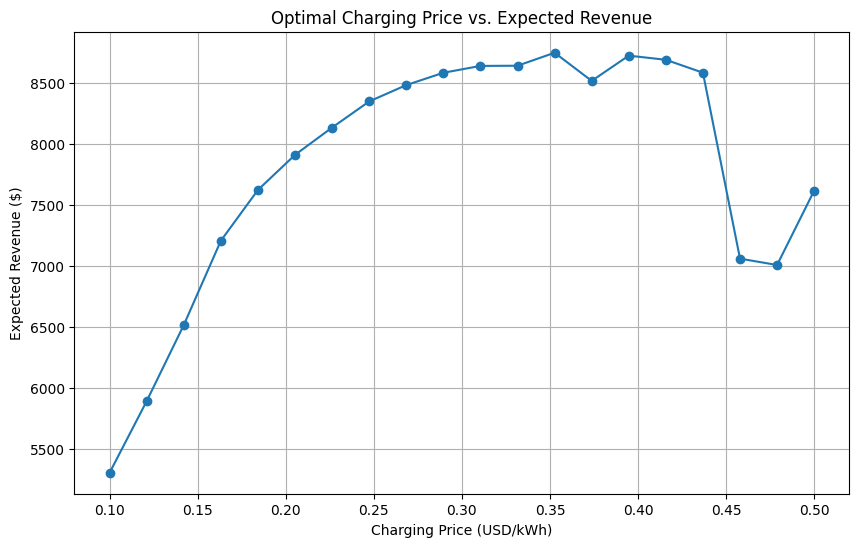

In [ ]:
import matplotlib.pyplot as plt

# Generating price values from $0.10 to $0.50
price_values = np.linspace(0.10, 0.50, 20)

# Calculating revenue for each price point
revenue_values = [-objective([p]) for p in price_values]

# Plotting Price vs. Revenue
plt.figure(figsize=(10, 6))
plt.plot(price_values, revenue_values, marker='o', linestyle='-')
plt.xlabel("Charging Price (USD/kWh)")
plt.ylabel("Expected Revenue ($)")
plt.title("Optimal Charging Price vs. Expected Revenue")
plt.grid(True)
plt.show()


## 7.4 Define Function to Optimize Pricing for Each City

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Function to calculate revenue per city using  our elasticity model
def revenue_per_city(price, demand_model, X_test_city):

    if X_test_city.empty:
        return 0  # Skip empty cities

    X_test_price = X_test_city.copy()
    X_test_price["cost_usd_per_kwh"] = price[0]

    # Predicttign demand category using trained RF classifier
    demand_pred = demand_model.predict(X_test_price)

    # Mapping demand clusters to expected users per day
    expected_demand = np.array([demand_mapping[d] for d in demand_pred])

    # Applying price elasticity (steeper demand drop at higher prices)
    elasticity_factor = np.exp(-3 * (price[0] - 0.30))  #  Decently aggressive drop-off
    adjusted_demand = expected_demand * elasticity_factor

    return np.sum(price[0] * adjusted_demand)  # Total revenue for given price


## 7.5 Optimize Charging Price for Each City

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Getting unique cities
cities = df_cleaned["city"].unique()

# Storing results
optimal_prices = []

for city in cities:
    print(f"Optimizing price for {city}...")

    # Filtering test data for the city
    X_test_city = X_test_class[df_cleaned["city"] == city]

    # Skipping if no data for the city
    if X_test_city.empty:
        continue

    # Defining objective function (negative revenue for maximization)
    def objective(price):
        return -revenue_per_city(price, rf_classifier, X_test_city)

    # Optimizing price for this city
    result = minimize(objective, x0=[0.25], bounds=[(0.10, 0.50)], method='L-BFGS-B')

    # Storing result
    optimal_prices.append({"City": city, "Optimal Price (USD/kWh)": result.x[0]})

# Convert to DataFrame
df_optimal_prices = pd.DataFrame(optimal_prices)

# Display results
df_optimal_prices


Optimizing price for San Francisco...
Optimizing price for Bangkok...
Optimizing price for Toronto...
Optimizing price for Mumbai...
Optimizing price for São Paulo...
Optimizing price for Moscow...
Optimizing price for Chicago...
Optimizing price for Beijing...
Optimizing price for Berlin...
Optimizing price for Seoul...
Optimizing price for Mexico City...
Optimizing price for Cape Town...
Optimizing price for Sydney...
Optimizing price for Los Angeles...
Optimizing price for Dubai...


,City,Optimal Price (USD/kWh)
0,San Francisco,0.312498
1,Bangkok,0.337754
2,Toronto,0.333333
3,Mumbai,0.500000
4,São Paulo,0.350003
5,Moscow,0.337500
6,Chicago,0.312500
7,Beijing,0.250000
8,Berlin,0.333333
9,Seoul,0.324854


## 7.6 Visualize City-Wise Pricing

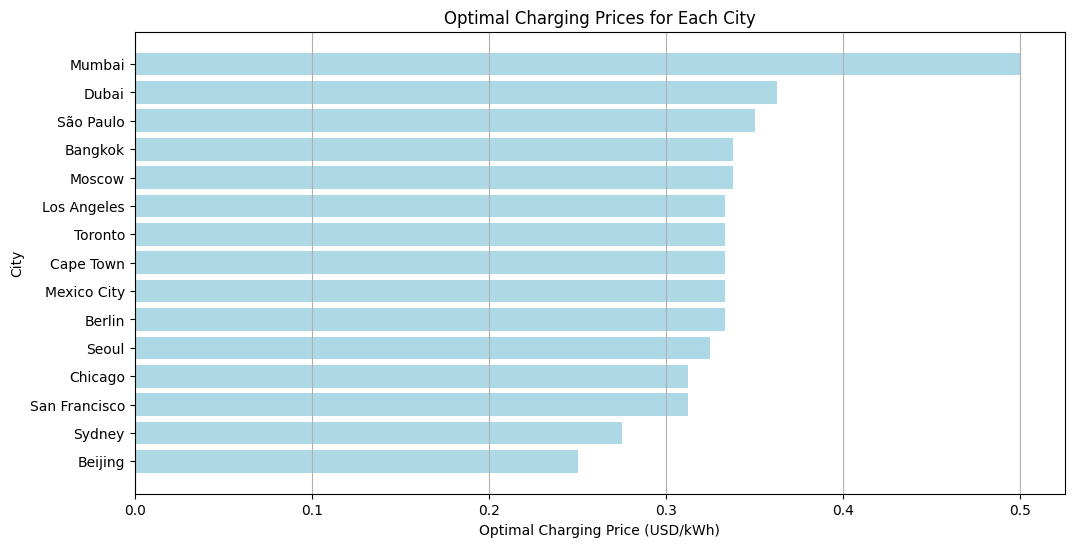

In [ ]:
import matplotlib.pyplot as plt

# Sortting by price for better visualization
df_optimal_prices_sorted = df_optimal_prices.sort_values(by="Optimal Price (USD/kWh)")

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(df_optimal_prices_sorted["City"], df_optimal_prices_sorted["Optimal Price (USD/kWh)"], color="lightblue")
plt.xlabel("Optimal Charging Price (USD/kWh)")
plt.ylabel("City")
plt.title("Optimal Charging Prices for Each City")
plt.grid(axis="x")
plt.show()
